<a href="https://colab.research.google.com/github/rugvedbairagi26/Diabetic-retinopathy/blob/main/APTOS_DR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
BASE_DIR = '/content/drive/MyDrive'

In [ ]:
TRAIN_IMG_DIR= BASE_DIR + '/train_images/'
TRAIN_CSV = BASE_DIR + '/train.csv'

In [ ]:
import os
print(os.listdir(BASE_DIR))

['Colab Notebooks', 'test.csv', 'train.csv', 'test_images', 'train_images', 'splits']


In [ ]:
import pandas as pd
df = pd.read_csv(TRAIN_CSV)
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


BUILDING IMAGE PATHS

In [ ]:
df = pd.read_csv(TRAIN_CSV)
df["image_path"] = df["id_code"].apply(lambda x: TRAIN_IMG_DIR + "/" + x + ".png")
df.head()


,id_code,diagnosis,image_path
0,000c1434d8d7,2,/content/drive/MyDrive/train_images//000c1434d...
1,001639a390f0,4,/content/drive/MyDrive/train_images//001639a39...
2,0024cdab0c1e,1,/content/drive/MyDrive/train_images//0024cdab0...
3,002c21358ce6,0,/content/drive/MyDrive/train_images//002c21358...
4,005b95c28852,0,/content/drive/MyDrive/train_images//005b95c28...


Dataset Loading and Image Path Construction

The APTOS 2019 dataset provides image IDs and severity labels in a CSV file.
Since the actual images are stored separately in a folder, I first construct the full image path for each sample by combining:

1) image directory path

2. image ID

3. .png extension

After creating the image paths, I verify that the files actually exist on disk using os.path.exists() for a few samples.
This step is important to avoid silent training failures caused by broken paths or missing files.

In [ ]:
for p in df['image_path'].head(5):
  print(p,os.path.exists(p))

/content/drive/MyDrive/train_images//000c1434d8d7.png True
/content/drive/MyDrive/train_images//001639a390f0.png True
/content/drive/MyDrive/train_images//0024cdab0c1e.png True
/content/drive/MyDrive/train_images//002c21358ce6.png True
/content/drive/MyDrive/train_images//005b95c28852.png True


CLASSS DISTRIBUTION ANALYSIS

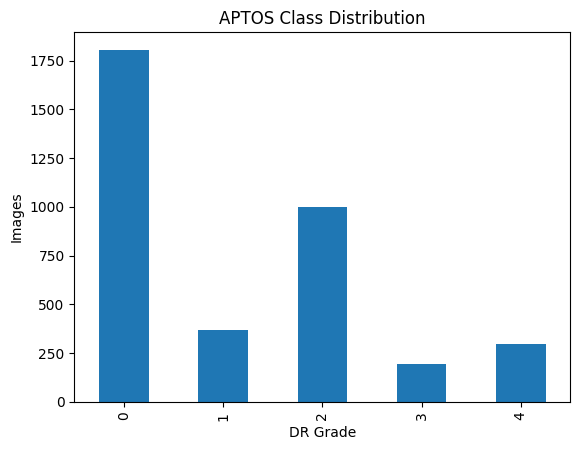

In [ ]:
import matplotlib.pyplot as plt

df["diagnosis"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("DR Grade")
plt.ylabel("Images")
plt.title("APTOS Class Distribution")
plt.show()


THIS PLOT SHOWS THAT THE APTOS DATASET IS HIGHLY IMBALANCE

Class: 0


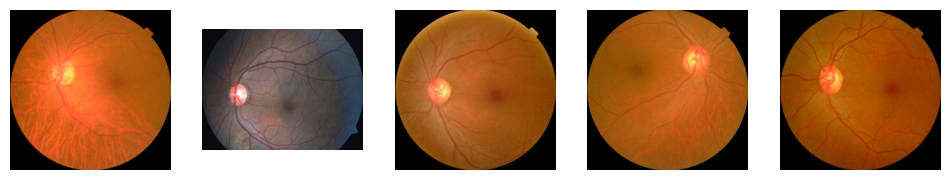

Class: 1


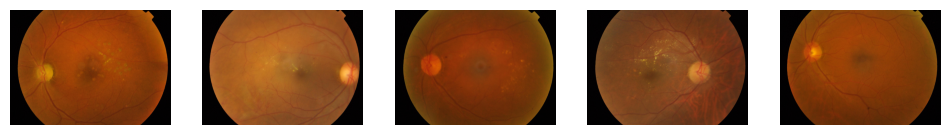

Class: 2


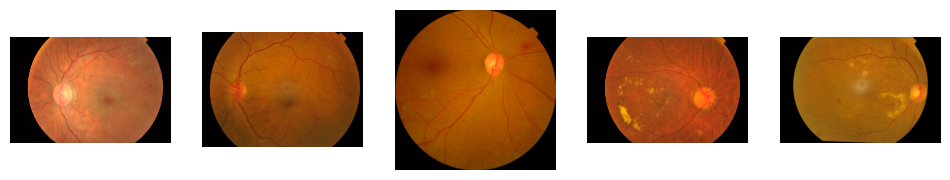

Class: 3


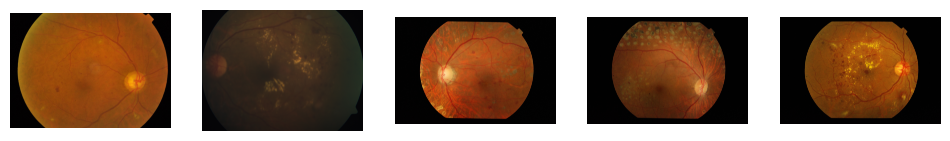

Class: 4


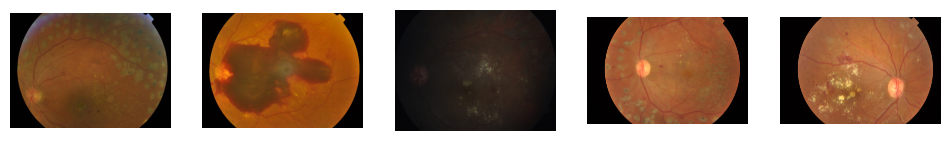

In [ ]:
from PIL import Image

for c in sorted(df["diagnosis"].unique()):
    print("Class:", c)
    sample = df[df["diagnosis"] == c].sample(5, random_state=42)
    plt.figure(figsize=(12,3))
    for i, p in enumerate(sample["image_path"]):
        plt.subplot(1,5,i+1)
        plt.imshow(Image.open(p))
        plt.axis("off")
    plt.show()


Before training any model, I analyze the dataset to understand:

1) class distribution

2) visual characteristics of each severity level

The bar plot shows that the dataset is highly imbalanced, with very few samples in the Severe and Proliferative DR categories.
This imbalance is expected in real clinical data but makes learning harder for minority classes.

I also visualize random images from each class to observe:

1) lesion severity

2) brightness variation

3) noise and background artifacts

This helped me understand that resizing and preprocessing strategies would be important for stable training.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["diagnosis"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["diagnosis"], random_state=42)

print(len(train_df), len(val_df), len(test_df))


2563 549 550


Stratified Dataset Splitting

To evaluate the model fairly, I split the dataset into:

1) Training set (70%)

2) Validation set (15%)

3) Test set (15%)

Since the dataset is highly imbalanced, I use stratified splitting based on class labels so that each split preserves the original class distribution.

This avoids situations where rare classes appear mostly in one split, which would lead to unreliable performance estimates.

The final splits are saved as CSV files to ensure reproducibility.


SAVE SPLITS

In [ ]:
SPLIT_DIR = BASE_DIR + "/splits"
os.makedirs(SPLIT_DIR, exist_ok=True)

train_df.to_csv(SPLIT_DIR + "/train.csv", index=False)
val_df.to_csv(SPLIT_DIR + "/val.csv", index=False)
test_df.to_csv(SPLIT_DIR + "/test.csv", index=False)



In [ ]:
!cp -r /content/drive/MyDrive/train_images /content/train_images

In [ ]:
OLD_PATH = "/content/drive/MyDrive/train_images"
NEW_PATH = "/content/train_images"

train_df["image_path"] = train_df["image_path"].str.replace(OLD_PATH, NEW_PATH)
val_df["image_path"]   = val_df["image_path"].str.replace(OLD_PATH, NEW_PATH)
test_df["image_path"]  = test_df["image_path"].str.replace(OLD_PATH, NEW_PATH)

print(train_df["image_path"].iloc[0])



/content/train_images//38f1901f214a.png


Improving Data Loading Performance

Loading images directly from Google Drive is slow and can become a bottleneck during training.
To improve I/O performance, I copy all training images to the local Colab runtime directory:

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_df['diagnosis'] = train_df['diagnosis'].astype(str)
val_df['diagnosis'] = val_df['diagnosis'].astype(str)
test_df['diagnosis'] = test_df['diagnosis'].astype(str)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col="image_path", y_col="diagnosis",
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode="sparse", shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col="image_path", y_col="diagnosis",
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode="sparse", shuffle=False
)

test_gen = val_datagen.flow_from_dataframe(
    test_df, x_col="image_path", y_col="diagnosis",
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode="sparse", shuffle=False
)

Found 2563 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.


Image Preprocessing and Batch Generation

I use ImageDataGenerator to:

1) resize images to 224×224

2) apply model-specific normalization

3) perform light data augmentation

For ResNet and EfficientNet, I use their respective preprocessing functions so that input images match the distribution of ImageNet training data.

Horizontal flipping is applied to improve generalization, while more aggressive augmentation is avoided to prevent distortion of medical features.

Generators also help load images in batches, which is memory efficient for large datasets.

BUILDING RESNET50 MODEL

In [ ]:
from tensorflow.keras import layers, models

base_model = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet",
    input_shape=(224,224,3)
)
base_model.trainable = False

model_rn = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(5, activation="softmax")
])

model_rn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_rn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Baseline Model: ResNet50 Transfer Learning

As a baseline, I use ResNet50 pretrained on ImageNet.

The convolutional backbone is frozen so that:

1) pretrained visual features are reused

2) only the classifier layers are trained on medical data

A custom classification head is added:

1) Global Average Pooling

2) Dense layer (256 neurons)

3) Dropout for regularization

4) Softmax output for 5-class classification

This setup allows me to evaluate how well generic visual features perform on retinal images.

In [ ]:
model_rn.fit(train_gen, validation_data=val_gen, epochs=8)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 332s 4s/step - accuracy: 0.6135 - loss: 1.2537 - val_accuracy: 0.7322 - val_loss: 0.7369
Epoch 2/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 307s 4s/step - accuracy: 0.7216 - loss: 0.7350 - val_accuracy: 0.7341 - val_loss: 0.7004
Epoch 3/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.7550 - loss: 0.6498 - val_accuracy: 0.7577 - val_loss: 0.6801
Epoch 4/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 308s 4s/step - accuracy: 0.7733 - loss: 0.6275 - val_accuracy: 0.7632 - val_loss: 0.6404
Epoch 5/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 307s 4s/step - accuracy: 0.7543 - loss: 0.6342 - val_accuracy: 0.7687 - val_loss: 0.6352
Epoch 6/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 307s 4s/step - accuracy: 0.7744 - loss: 0.5836 - val_accuracy: 0.7723 - val_loss: 0.6405
Epoch 7/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.8092 - loss: 0.5208 - val_accuracy: 0.7650 - val_loss: 0.6303
Epoch 8/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 308s 4s/step - accuracy: 0.7857 - loss: 0.5566 - val_accuracy: 0.7687 - val_loss:

18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step
              precision    recall  f1-score   support

           0     0.9599    0.9705    0.9651       271
           1     0.6000    0.3214    0.4186        56
           2     0.6116    0.9133    0.7326       150
           3     1.0000    0.0345    0.0667        29
           4     0.4762    0.2273    0.3077        44

    accuracy                         0.7800       550
   macro avg     0.7295    0.4934    0.4981       550
weighted avg     0.7917    0.7800    0.7461       550



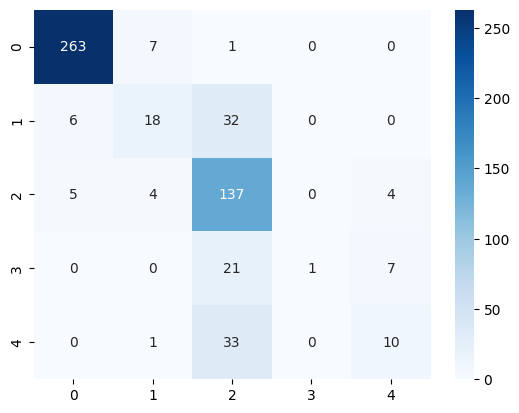

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_gen.reset()
preds = model_rn.predict(test_gen)
y_pred = preds.argmax(axis=1)
y_true = test_df["diagnosis"].values.astype(int)

print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

Baseline Model Evaluation

The baseline model achieves reasonable accuracy on majority classes, but recall is very low for:

1) Severe DR

2) Proliferative DR

This is expected due to:

1) class imbalance

2) subtle differences between advanced stages

This result motivates trying a stronger architecture and fine-tuning pretrained features.

In [ ]:
MODEL_DIR = BASE_DIR + "/models"
os.makedirs(MODEL_DIR, exist_ok=True)

model_rn.save(MODEL_DIR + "/resnet50_baseline.h5")


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Ensure 'diagnosis' is string type and create a 'class' column for compatibility
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
train_df['class'] = train_df['diagnosis']
val_df['diagnosis'] = val_df['diagnosis'].astype(str)
val_df['class'] = val_df['diagnosis']
test_df['diagnosis'] = test_df['diagnosis'].astype(str)
test_df['class'] = test_df['diagnosis']

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col="image_path", y_col="diagnosis",
    target_size=(224,224), batch_size=32, class_mode="sparse"
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col="image_path", y_col="diagnosis",
    target_size=(224,224), batch_size=32, class_mode="sparse", shuffle=False
)

test_gen = val_datagen.flow_from_dataframe(
    test_df, x_col="image_path", y_col="diagnosis",
    target_size=(224,224), batch_size=32, class_mode="sparse", shuffle=False
)

Found 2563 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.


In [ ]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet",
    input_shape=(224,224,3)
)
base_model.trainable = False

model_eff = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(5, activation="softmax")
])

model_eff.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_eff.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,912 (16.72 MB)

 Trainable params: 331,781 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

Improved Model: EfficientNetB0

EfficientNetB0 is used because it provides:

1) better parameter efficiency

2) stronger feature extraction compared to ResNet

Training is performed in two stages:

 Stage 1 — Feature Extraction

All backbone layers are frozen and only the classifier is trained.

 Stage 2 — Fine-Tuning

Upper convolution layers are unfrozen while lower layers remain frozen to prevent overfitting.

Learning rate is reduced during fine-tuning to avoid damaging pretrained weights.

This approach allows the model to adapt to retinal lesion patterns while retaining general visual features.

In [ ]:
model_eff.fit(train_gen, validation_data=val_gen, epochs=8)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 378s 4s/step - accuracy: 0.6223 - loss: 1.1671 - val_accuracy: 0.7450 - val_loss: 0.7602
Epoch 2/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.7735 - loss: 0.6681 - val_accuracy: 0.7741 - val_loss: 0.6746
Epoch 3/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.8007 - loss: 0.5125 - val_accuracy: 0.7505 - val_loss: 0.6523
Epoch 4/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.8223 - loss: 0.4951 - val_accuracy: 0.7851 - val_loss: 0.5867
Epoch 5/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 307s 4s/step - accuracy: 0.8403 - loss: 0.4444 - val_accuracy: 0.7887 - val_loss: 0.5912
Epoch 6/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 307s 4s/step - accuracy: 0.8389 - loss: 0.4323 - val_accuracy: 0.7960 - val_loss: 0.6008
Epoch 7/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.8588 - loss: 0.3985 - val_accuracy: 0.7869 - val_loss: 0.6347
Epoch 8/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.8540 - loss: 0.3834 - val_accuracy: 0.7778 - val_loss:

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

model_eff.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_eff.fit(train_gen, validation_data=val_gen, epochs=15)


Epoch 1/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.7213 - loss: 0.7621 - val_accuracy: 0.7978 - val_loss: 0.7371
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.8138 - loss: 0.4971 - val_accuracy: 0.7960 - val_loss: 0.7847
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.8191 - loss: 0.4621 - val_accuracy: 0.8015 - val_loss: 0.6753
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.8483 - loss: 0.3932 - val_accuracy: 0.8033 - val_loss: 0.6696
Epoch 5/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 307s 4s/step - accuracy: 0.8779 - loss: 0.3397 - val_accuracy: 0.7978 - val_loss: 0.7354
Epoch 6/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.9008 - loss: 0.2795 - val_accuracy: 0.7978 - val_loss: 0.7035
Epoch 7/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.9060 - loss: 0.2556 - val_accuracy: 0.7869 - val_loss: 0.7041
Epoch 8/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.8936 - loss: 0.2937 - val_accuracy: 0.8087 - v

18/18 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step
              precision    recall  f1-score   support

           0     0.9744    0.9815    0.9779       271
           1     0.6087    0.5000    0.5490        56
           2     0.7386    0.8667    0.7975       150
           3     0.5909    0.4483    0.5098        29
           4     0.6364    0.4773    0.5455        44

    accuracy                         0.8327       550
   macro avg     0.7098    0.6548    0.6760       550
weighted avg     0.8256    0.8327    0.8258       550



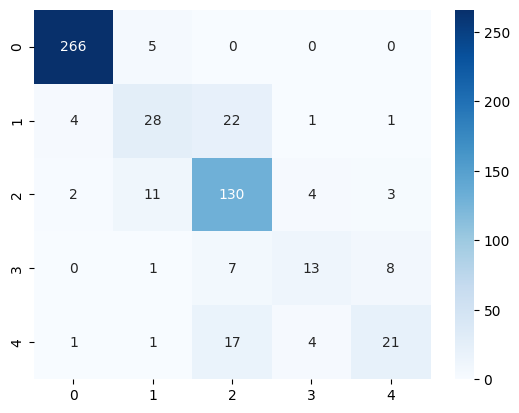

In [ ]:
test_gen.reset()
preds = model_eff.predict(test_gen)
y_pred = preds.argmax(axis=1)

print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()


Compared to the baseline ResNet model, EfficientNet shows:

1) higher overall accuracy

2) improved recall for minority classes

3) better macro-averaged F1 score

However, confusion still exists between:

1) Moderate vs Severe DR

2) Severe vs Proliferative DR

These categories often share visual similarities, and even human grading can be subjective in borderline cases.

In [ ]:
model_eff.save(MODEL_DIR + "/efficientnet_final.h5")


Model Saving for Future Experiments

The trained models are saved to disk so they can be reused for:

1) inference experiments

2) Grad-CAM visualization

3) further fine-tuning

4) deployment experiments

Saving models also helps in reproducibility and future comparison studies.

Future Improvements

Planned next steps for this project include:

  Grad-CAM Visualization

To visualize where the CNN focuses in retinal images and verify whether predictions are based on lesion regions instead of background artifacts.

  Class Imbalance Handling

Experiments with:

1) class-weighted loss

2) focal loss
to improve recall for severe disease categories.